In [1]:
%matplotlib notebook
import netgen.gui
from ngsolve import *
import matplotlib.pyplot as plt
from netgen.geom2d import CSG2d, Circle, Rectangle, Solid2d
import numpy as np

In [2]:
geo = CSG2d()

# Define some shapes
inner_circle = Circle(center=(0,0), radius=1, mat="Omega", bc="omega_bc")
circle = Circle(center=(0.2,0.7), radius=0.1, mat="mat1", bc="bc_circle")
tri = Solid2d( [(0.5,0.4), (0.1,-0.2), (0.9,-0.2)], mat="mat1", bc="bc_tri" )
rect1 = Rectangle( pmin=(-0.5,-0.5), pmax=(-0.1,-0.1), mat="mat2", bc="bc_rect1")
rect2 = Rectangle( pmin=(-0.1,0.1), pmax=(-0.5,0.5), mat="mat2", bc="bc_rect2")
pml_circle = Circle(center=(0,0), radius=2.0, mat="pml", bc="pml_bc")

domain1 = rect1 + rect2
domain1.Mat("solid_1")
domain2 = tri + circle - domain1
domain2.Mat("solid_2")
domain3 = inner_circle - domain1 - domain2
domain3.Mat("Omega1")
domain4 = pml_circle - inner_circle
domain4.Mat("pml")

# Add materials and domains to the geometry.
geo.Add(domain1)
geo.Add(domain2)
geo.Add(domain3)
geo.Add(domain4)

mesh = Mesh(geo.GenerateMesh (maxh=0.05))

mesh.SetPML(pml.Radial(rad=1.85,alpha=1j,origin=(0,0)), "pml")

#Define some values/functions for k within the shapes/domains.
k_tot = 72
k_2 = 71
k_3 = 69

domain_values = {'solid_1': k_2,'solid_2': k_3, 'Omega1': k_tot, 'pml': k_tot}
values_list = [domain_values[mat] for mat in mesh.GetMaterials()]
k = CoefficientFunction(values_list)

In [3]:
fes = H1(mesh, complex=True, order=5, dirichlet="domain_bc")

n = specialcf.normal(2)

def forward_pass(theta):

    u_in = exp(1j*k_tot*(cos(theta)*x + sin(theta)*y)) #Incoming Plane Wave. 

    #Defining our test and solution functions.
    u = fes.TrialFunction()
    v = fes.TestFunction()

    #Defining our LHS of the weak formulation.
    a = BilinearForm(fes)
    a += grad(u) * grad(v) * dx
    a += - k**2 * u * v * dx
    
    #Defining the RHS of our weak formulation.
    f = LinearForm(fes)
    f += -u_in * (k**2 - k_tot**2) * v * dx
    
    a.Assemble()
    f.Assemble()

    #Solving our problem.
    u_s = GridFunction(fes, name="u")
    u_s.vec.data = a.mat.Inverse() * f.vec

    u_tot = u_in + u_s
    
    return [u_in, u_s, u_tot]

s = (17/37)*np.pi

calc = forward_pass(s)
u_in = calc[0]
u_s = calc[1]
u_tot = calc[2]

#This allows us to see the solutions on the NGSolve gui.
Draw(u_in, mesh, "u_in")
Draw(u_s, mesh, "u_s")
Draw(u_tot, mesh, "u_tot")

**Note:** Please change the colour scale in the visual pop out menu! The mesh can be removed in the View -> Viewing Options -> Mesh section.

<IPython.core.display.Javascript object>


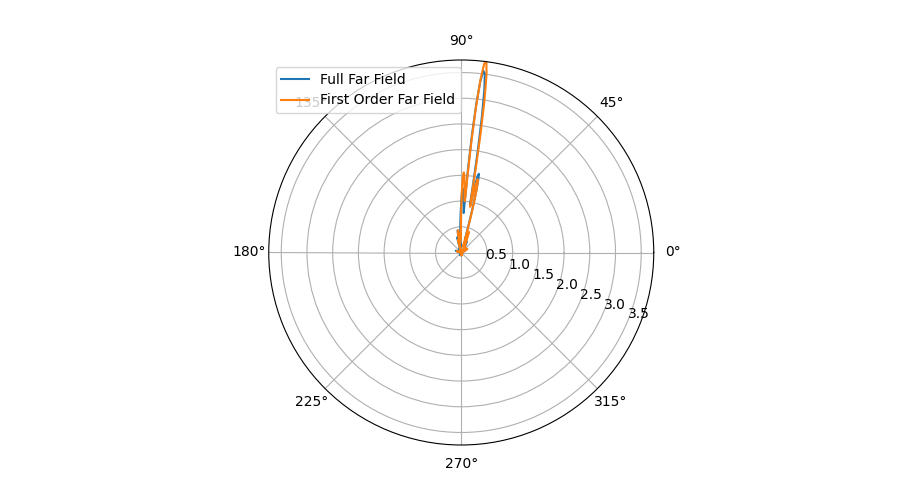

<IPython.core.display.Javascript object>


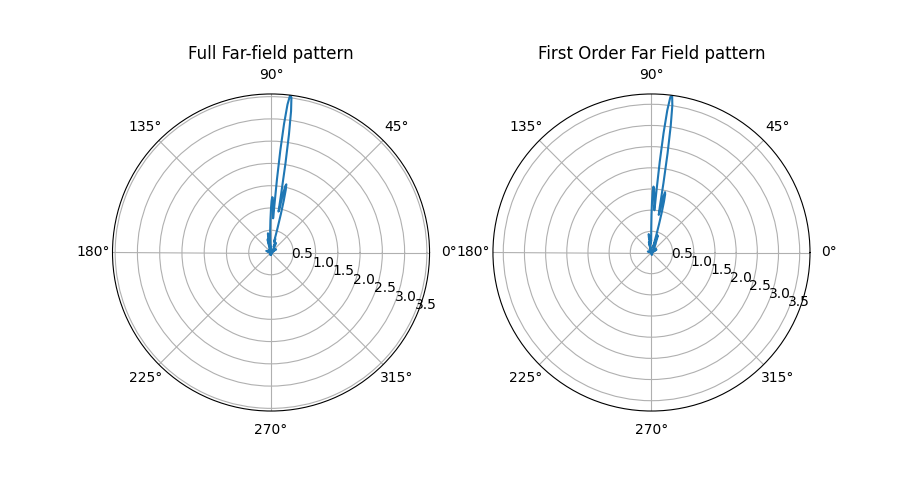

In [6]:
def f1_field(r,s):
    
    temp = Integrate(exp(-1j*k_tot*((cos(r)-cos(s))*x+(sin(r)-sin(s))*y))*(k**2 - k_tot**2),
              mesh,definedon=mesh.Materials("solid_1|solid_2|Omega1"))
    
    return (exp(1j*r)/np.sqrt(8*np.pi*k_tot))*temp

def ff_field(r):
    
    n = specialcf.normal(2)
    us_n = BoundaryFromVolumeCF(Grad(u_s)*n)
    ecomp = exp(-1j*k_tot*(cos(r)*x + sin(r)*y))
    ecomp_n = CoefficientFunction((ecomp.Diff(x),ecomp.Diff(y)))*n
    
    temp = Integrate(u_s*ecomp_n - us_n*ecomp, mesh,definedon=mesh.Boundaries("omega_bc"))
    
    return (exp(1j*r)/np.sqrt(8*np.pi*k_tot))*temp

theta = np.arange(0, 2*np.pi, 0.01)

mag1 = []

mag2 = []

for r in theta:
    
    mag1.append(abs(ff_field(r)))
    
    mag2.append(abs(f1_field(r,s)))
    
fig = plt.figure(figsize=(9, 5))

ax = plt.subplot(1, 1, 1, projection='polar')

ax.plot(theta, mag1)
ax.plot(theta, mag2)
ax.set_rmax(max(mag2))
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
plt.legend(["Full Far Field", "First Order Far Field"])

plt.show()

fig2 = plt.figure(figsize=(9, 5))

ax = plt.subplot(1, 2, 1, projection='polar')

ax.plot(theta, mag1)
ax.set_rmax(max(mag1))
ax.set_rlabel_position(-22.5)
ax.grid(True)
plt.title('Full Far-field pattern')

ax = plt.subplot(1, 2, 2, projection='polar')

ax.plot(theta, mag2)
ax.set_rmax(max(mag2))
ax.set_rlabel_position(-22.5)
ax.grid(True)
plt.title('First Order Far Field pattern')

plt.show()